In [1]:
import cv2 as cv
import numpy as np
import copy
%matplotlib inline
import matplotlib.pyplot as plt

### 1) Read image

In [2]:
img = cv.imread('Lenna.png')

In [ ]:
# this showing image in separate window so i wont use such approach
cv.imshow('image', img)
cv.waitKey(0)
cv.destroyAllWindows()

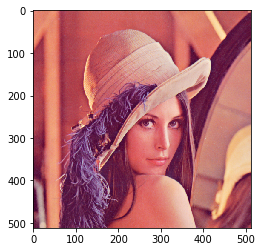

In [3]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### 2) Transform to  grayscale
Grayscale is a range of monochromatic shades from black to white. 

More [here](https://techterms.com/definition/grayscale). 

[cvtColor](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cvtcolor)

In [4]:
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

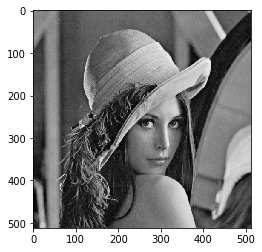

In [5]:
plt.imshow(gray, cmap='gray')

In [6]:
height = img.shape[0]
width = img.shape[1]
print('height: ', height, "\nwidth : ", width)

height:  512 
width :  512


### 3) Improve contrast

We want to stretch out the intensity range.

More [here](https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html) and [here](https://www.coursera.org/lecture/deep-learning-in-computer-vision/contrast-and-brightness-correction-JTX5e).

[equalizeHist](https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/histogram_equalization/histogram_equalization.html)

In [7]:
contrast_img = cv.equalizeHist(gray)

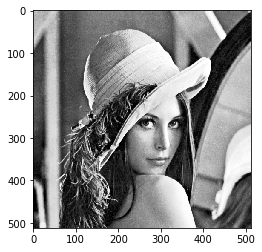

In [8]:
plt.imshow(contrast_img, cmap='gray')

### 4) Search edge points

We want to find sharp non-noise changes intensities corresponding the boundaries of objects on the stage.

More [here](https://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html), [here](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny).

[Canny](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)

In [9]:
canny_img_improve = cv.Canny(contrast_img, 300, 200)
canny_img_gray = cv.Canny(gray, 300, 200)

In [10]:
def plot_two_img(improve_contrast, gray, color=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('With improve contrast')
    ax2.set_title('Just gray image')
    if (color):
        ax1.imshow(improve_contrast)
        ax2.imshow(gray)
    else:
        ax1.imshow(improve_contrast, cmap='gray')
        ax2.imshow(gray, cmap='gray')

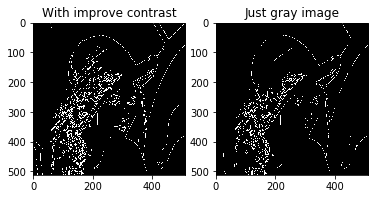

In [12]:
plot_two_img(canny_img_improve, canny_img_gray)

### 5) Corners detection

Corners are regions in the image with large variation in intensity in all the directions.

More [here](https://medium.com/pixel-wise/detect-those-corners-aba0f034078b), [here](https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html) and [here](https://docs.opencv.org/2.4/doc/tutorials/features2d/trackingmotion/harris_detector/harris_detector.html).

[goodFeaturesToTrack](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#goodfeaturestotrack)

In [11]:
def draw_corners(corners_img, corners):
    for corner in corners:
        x, y = corner.ravel()
        cv.circle(corners_img, center=(x, y), radius=2, color=(255,69,0), thickness=-1)

def img_with_corners(img_):
    corners = cv.goodFeaturesToTrack(copy.deepcopy(img_), maxCorners=100, qualityLevel=0.4, minDistance=2)
    corners_img = copy.deepcopy(img_)
    draw_corners(corners_img, corners)

    return corners_img

### Only for show i'm specified radius like 10 instead 2 because matplotlib has trouble with colors 

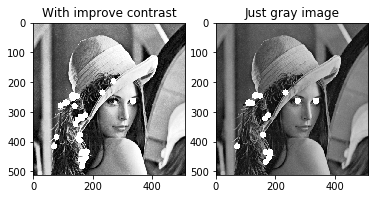

In [16]:
plot_two_img(img_with_corners(contrast_img), img_with_corners(gray))

### 6) Distance transform

We want get distance map by calculates the distance to the closest zero pixel for each pixel of the source image.

More [here](https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm) and [here](https://stackoverflow.com/questions/22563838/understanding-distance-transform-in-opencv)

[distanceTransform](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042)

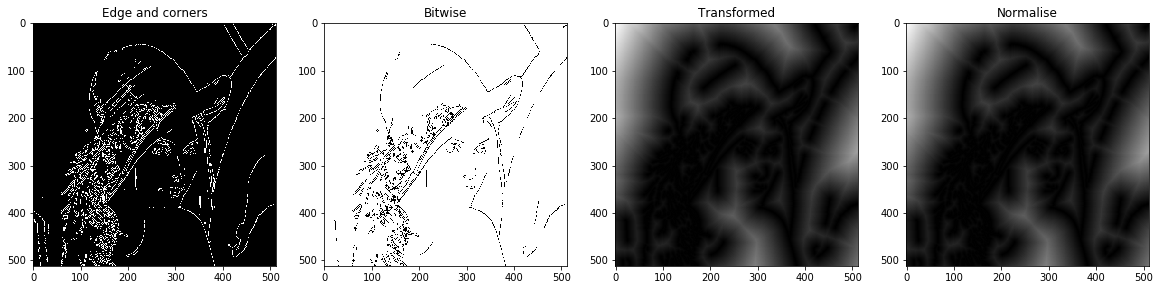

In [12]:
edges = canny_img_gray

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))

edge_and_corners = img_with_corners(edges)
ax1.set_title('Edge and corners')
ax1.imshow(canny_img_improve, cmap='gray')

cv.bitwise_not(edge_and_corners, edge_and_corners)
ax2.set_title('Bitwise')
ax2.imshow(edge_and_corners, cmap='gray')

dist_transform = cv.distanceTransform(edge_and_corners, distanceType=cv.DIST_L2, maskSize=3)
ax3.set_title('Transformed')
ax3.imshow(dist_transform, cmap='gray')

normalized = np.zeros(shape=[height,width,3], dtype=np.uint8)
normalized = cv.normalize(copy.deepcopy(dist_transform), normalized, alpha=0, beta=1., norm_type=cv.NORM_MINMAX)
ax4.set_title('Normalise')
ax4.imshow(normalized, cmap='gray')


## 7) Image filtering 

by averaging relative on distance to edge and corner points

In [15]:
def get_average_px(gray_image, radius, x, y):
    radius = int(radius)
    neighbors = []
    if (radius<1):
        radius=1
    
    for l in range(-radius, radius):
        for k in range(-radius, radius):
            neighbors.append(bounded(gray_image, x + k, y + l))
    
    if neighbors == []:
        return gray_image[y, x]
    
    avg = int(sum(neighbors)/len(neighbors))
    
    return avg

def bounded(image, x, y):
    if x < 0:
        x = 0
    if x > image.shape[1] - 1:
        x = image.shape[1] - 1
    if y < 0:
        y = 0
    if y > image.shape[0] - 1:
        y = image.shape[0] - 1
    
    return image[y, x]

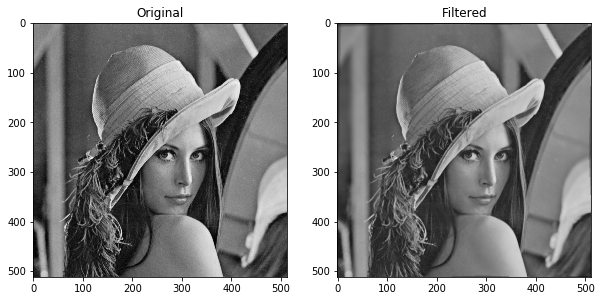

In [82]:
k = 10
avg_image = np.zeros(shape=[height,width,3], dtype=np.uint8)

for y in range(height):
    for x in range(width):
        window_radius = k * normalized[y, x]
        px = get_average_px(gray, window_radius, x, y)

        avg_image[y, x] = px
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.set_title('Original')
ax1.imshow(gray, cmap='gray')

ax2.set_title('Filtered')
ax2.imshow(avg_image, cmap='gray')

## 8) Filtering with integral image

In [94]:
def get_filtered_img(k):
    integral_image = cv.integral(gray)

    filtered_image = np.zeros(shape=[height,width,3], dtype=np.uint8)

    for y in range(0, height):
        for x in range(0, width):
            r = min(int(k * dist_transform[y, x]), 3)

            A = bounded(integral_image, x - r, y - r)
            B = bounded(integral_image, x + r, y - r)
            C = bounded(integral_image, x + r, y + r)
            D = bounded(integral_image, x - r, y + r)
            
            sum_ = A + C - B - D
            length = (2 * r) ** 2
            px = (sum_ / length)
            filtered_image[y, x] = px
    return filtered_image

/home/daniil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


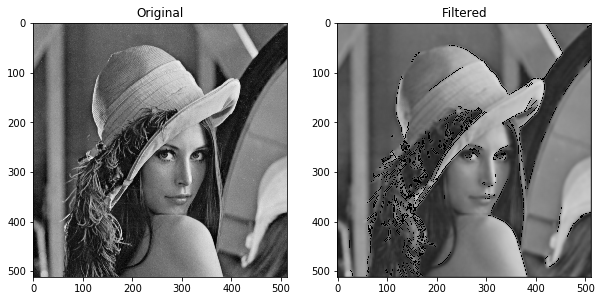

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

ax1.set_title('Original')
ax1.imshow(gray, cmap='gray')

ax2.set_title('Filtered')
ax2.imshow(get_filtered_img(10), cmap='gray')

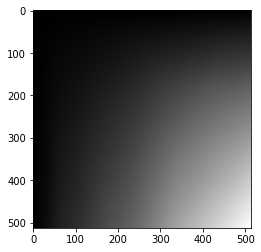

In [45]:
integral_image = cv.integral(gray)
plt.imshow(integral_image, cmap='gray')